# DM-42228: illustrate implementation of donut quality check with LSSTCam data




This data was simulated with `imsim` as part of DM-41453. The chosen visit 739388 corresponds to a high density field and provides plenty of overlapping sources. 

Setup:

* WEP: 9.2.0 , branch tickets/DM-42228

* 2024_04 stack

Run donut direct detection on several detectors:

In [1]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.table import Table
import numpy as np
path_cwd = '/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/'
butlerRootPath = os.path.join(path_cwd, 'gen3repo')
butler = dafButler.Butler(butlerRootPath)

# read in one run that has postISRCCD
runName ='run_739388'  # max_flux : 1e9   
day_obs = 280818
seqNumStart = 960
butlerInstName = 'Cam'
visit_intra = f'50{day_obs}00{seqNumStart}'
visit_extra = f'50{day_obs}00{seqNumStart+2}'

butlerRootPath = os.path.join(path_cwd, 'gen3repo')
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
#registry.queryCollections()

collection = 'runFAM_960_962_all_det_2024_02_ext_lim_12-15_bps_science'


# querying on `zernikeEstimateRaw` I get only extra-focal 
datasetRefs = registry.queryDatasets("zernikeEstimateRaw", collections=[collection],
              where=f"instrument='LSSTCam'").expanded()

refs = []
for ref in datasetRefs:
    #print(ref.dataId)
    refs.append(ref.dataId
               )


In [5]:
from lsst.ts.wep.task import GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import  ( 
    CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig)

from copy import copy 
from scipy.stats import entropy

def calc_entropy(donut_stamps):
    entropy_dic = {}
    for i in range(len(donut_stamps)):
        stamp = donut_stamps[i]
        d = stamp.stamp_im.image.array
       
        # these follow code from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/donutImageCheck.py
        array1d = d.flatten()
        entroThres = 3.5
        numOfBins = 256
        hist = np.histogram(array1d, bins=numOfBins)[0]
        # Square the distribution to magnify the difference in entropy
        imgEntropy = entropy(hist**2)
        entropy_dic[i] = {'donut':d, 'hist':hist, 'imgEntropy':imgEntropy}
    
    return entropy_dic


camera = butler.get(
    "camera",
    dataId={"instrument": "LSSTCam"},
    collections=["LSSTCam/calib/unbounded",],
)

donut_info = {}


# grab the i-th detector
for idx in range(80,98):#@96 
    print('\nCalculating:')
    print(refs[idx].detector)
    
    dataIdIntra = {'instrument':refs[idx]['instrument'], 
              'detector':refs[idx]['detector'],
              'visit':int(visit_intra),
              'exposure':int(visit_intra)
             }
    dataIdExtra = {'instrument':refs[idx]['instrument'], 
              'detector':refs[idx]['detector'],
              'visit':int(visit_extra),
              'exposure':int(visit_extra)
             }
    
    # Also load the postISR exposure:
    exposure_extra = butler.get('postISRCCD', 
                                  dataId=dataIdExtra, 
                                  collections=[runName]
                                )
    exposure_intra = butler.get('postISRCCD', 
                                  dataId=dataIdIntra, 
                                  collections=[runName]
                                )
    
    # Run donut detection
    config = GenerateDonutDirectDetectTaskConfig()
    
    # we're just using one defocal exposure here b.c the position
    # of sources would be identical 
    exposure = copy(exposure_intra) # crucial step!!!! 
    taskDirect = GenerateDonutDirectDetectTask(config=config)
    cat_extra_direct = taskDirect.run(exposure, camera)
    donut_catalog_direct = cat_extra_direct.donutCatalog
    
    
    # cutouts does both extra and intra 
    cutoutTaskConfig = CutOutDonutsScienceSensorTaskConfig()
    cutoutTask = CutOutDonutsScienceSensorTask(config=cutoutTaskConfig)
    
    cutoutResults = cutoutTask.run([exposure_intra, exposure_extra],
                  [donut_catalog_direct, donut_catalog_direct],
                  camera)
    donutStampsExtra = cutoutResults.donutStampsExtra
    
    # enhance the donut catalog with the extra-focal info 
    for colname in ['SN_RATIO_BASE',
     'SN_RATIO_DILATED',
     'SN_RATIO_HEADER',
     'EFFECTIVE']:
        donut_catalog_direct[colname] = donutStampsExtra.metadata.getArray(colname)
    
    donut_info[idx] = {}
    donut_info[idx]['detector'] = refs[idx]['detector']
    donut_info[idx]['catalog'] = donut_catalog_direct
    donut_info[idx]['entropy_dic'] = calc_entropy(donutStampsExtra)


Calculating:
detector:
  instrument: 'LSSTCam'
  id: 80
  full_name: 'R20_S22'
  name_in_raft: 'S22'
  raft: 'R20'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 27 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 27 of 27 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/27 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 81
  full_name: 'R21_S00'
  name_in_raft: 'S00'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 18 of 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 9/18 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 82
  full_name: 'R21_S01'
  name_in_raft: 'S01'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 26 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 26 of 26 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 17/26 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 83
  full_name: 'R21_S02'
  name_in_raft: 'S02'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/17 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 84
  full_name: 'R21_S10'
  name_in_raft: 'S10'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 13/17 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 85
  full_name: 'R21_S11'
  name_in_raft: 'S11'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 10 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 10 of 10 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 8/10 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 86
  full_name: 'R21_S12'
  name_in_raft: 'S12'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 22 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 22 of 22 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 17/22 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 87
  full_name: 'R21_S20'
  name_in_raft: 'S20'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 20 of 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 13/20 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 88
  full_name: 'R21_S21'
  name_in_raft: 'S21'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 23 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 23 of 23 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 11/23 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 89
  full_name: 'R21_S22'
  name_in_raft: 'S22'
  raft: 'R21'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 10 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 10 of 10 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/10 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 90
  full_name: 'R22_S00'
  name_in_raft: 'S00'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/17 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 91
  full_name: 'R22_S01'
  name_in_raft: 'S01'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 16 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 16 of 16 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 15/16 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 92
  full_name: 'R22_S02'
  name_in_raft: 'S02'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 24 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 24 of 24 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 19/24 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 93
  full_name: 'R22_S10'
  name_in_raft: 'S10'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 11/17 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 94
  full_name: 'R22_S11'
  name_in_raft: 'S11'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 31 of 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/31 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 95
  full_name: 'R22_S12'
  name_in_raft: 'S12'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 28 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 28 of 28 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 22/28 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 96
  full_name: 'R22_S20'
  name_in_raft: 'S20'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 10/17 references



Calculating:
detector:
  instrument: 'LSSTCam'
  id: 97
  full_name: 'R22_S21'
  name_in_raft: 'S21'
  raft: 'R22'
  purpose: 'SCIENCE'


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 14 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 14 of 14 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/14 references


In [7]:
np.save(f'donut_info_{runName}_visit_{visit_intra}_idx_80-97', donut_info)

Plot the donuts from a single sensor:

In [8]:
from scipy.stats import entropy
def plot_entropy(donut_stamps, donut_catalog, i):
    stamp = donut_stamps[i]
    fig = plt.figure(figsize=(9,3))#1, figsize=(3*edge, n_donuts*edge))
    ax1 = fig.add_axes([0, 0, 0.4, 1])
    ax2 = fig.add_axes([0.44, 0, 0.6, 1])
    
    d = stamp.stamp_im.image.array
    vmin,vmax = zscale.get_limits(d)
    
    ax1.imshow(d, vmin=vmin, vmax=vmax, origin="lower")
    ax1.set_title(f" donut {i}", fontsize=17, c="black")
    
    # these follow code from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/donutImageCheck.py
    array1d = d.flatten()
    entroThres = 3.5
    numOfBins = 256
    hist = np.histogram(array1d, bins=numOfBins)[0]
    imgEntropy = entropy(hist**2)
    ax2.plot(hist)
    
    # Square the distribution to magnify the difference in entropy
    
    
    eff = donut_catalog.iloc[i]['EFFECTIVE']
    sn1 = donut_catalog.iloc[i]['SN_RATIO_DILATED']
    sn2 = donut_catalog.iloc[i]['SN_RATIO_HEADER']
    
    text_dict = {'color':'b', 'fontsize':12, 'horizontalalignment':'left',
         'verticalalignment':'center'}
    sgn = '<'  if imgEntropy<entroThres else '>'
    # position in axis2 coords 
    x1 = 0.3 
    y1 = 0.4
    dy = 0.1 
    ax2.text(x1,y1+dy, f'entropy:{np.round(imgEntropy,2)} {sgn} {entroThres}',  transform=ax2.transAxes,  **text_dict)
    ax2.text(x1,y1,f'effective:{eff}',  transform=ax2.transAxes,**text_dict)
    ax2.text(x1,y1-dy,f'SN estimate: {np.round(sn1,2)}',  transform=ax2.transAxes, **text_dict)
    ax2.text(x1,y1-2*dy,f'SN header: {np.round(sn2,2)}', transform=ax2.transAxes, **text_dict)
    ax2.set_ylabel('histogram count')
    ax2.set_xlabel('histogram bin')
    #fig.subplots_adjust(hspace=0.4)

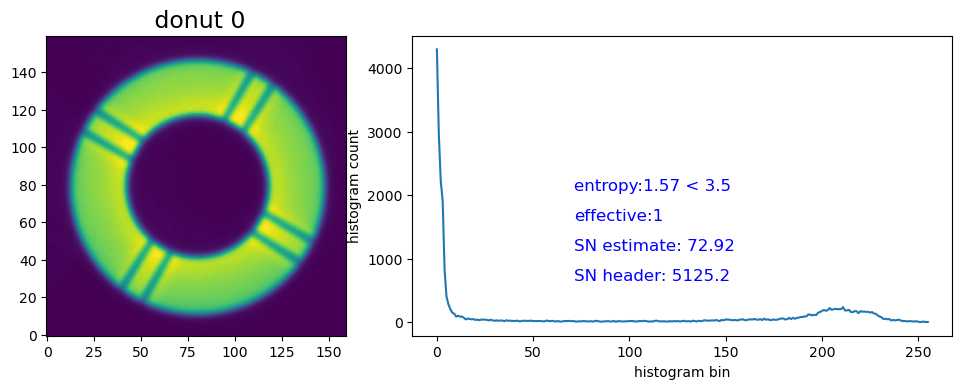

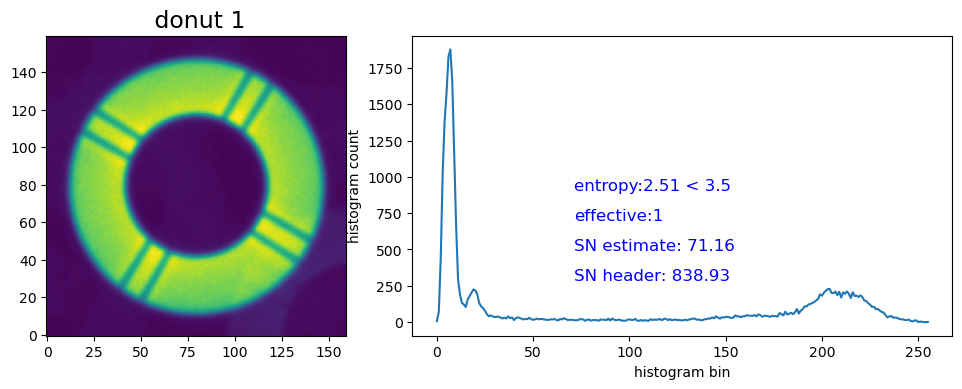

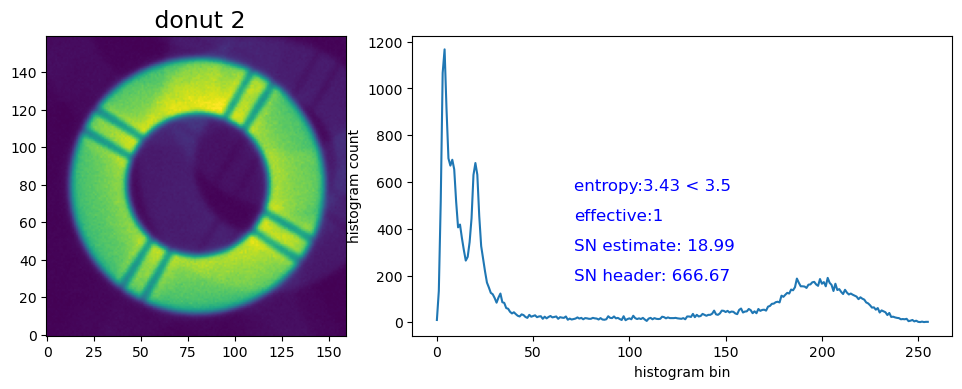

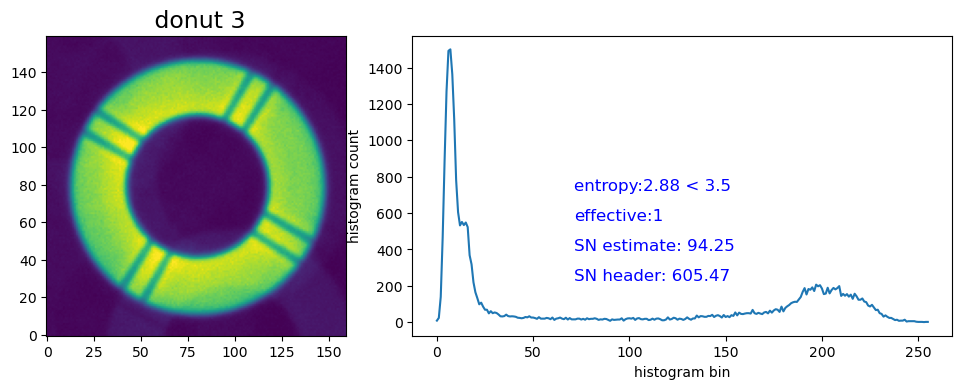

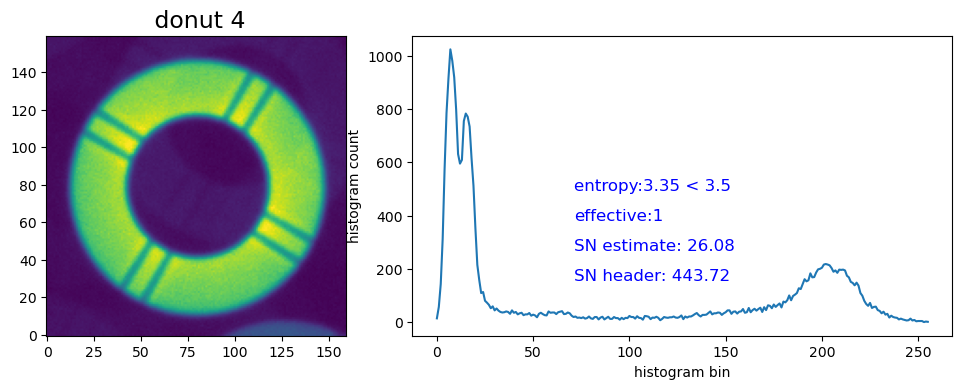

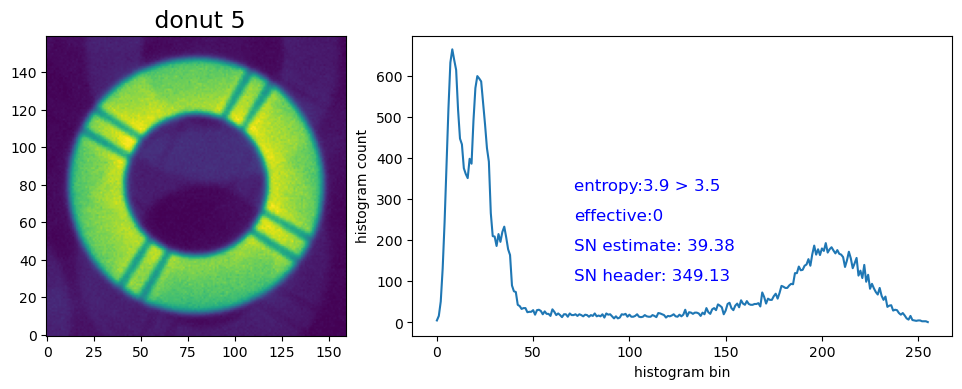

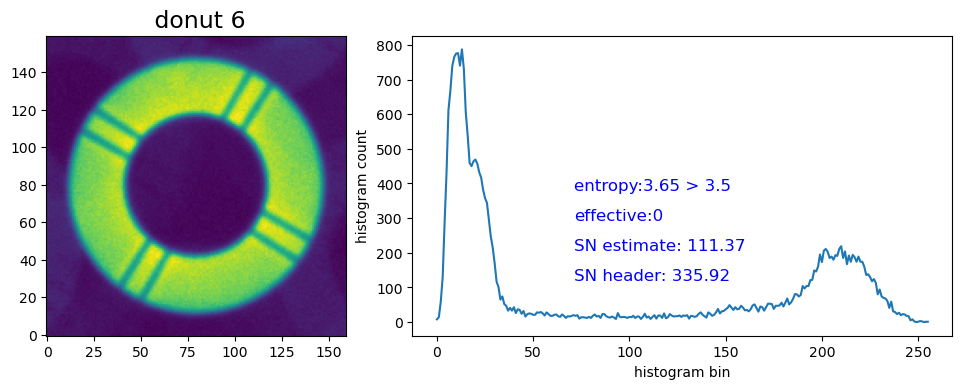

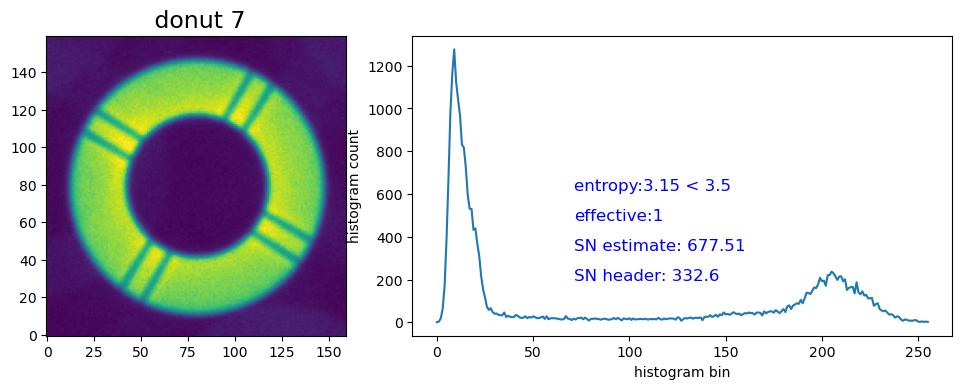

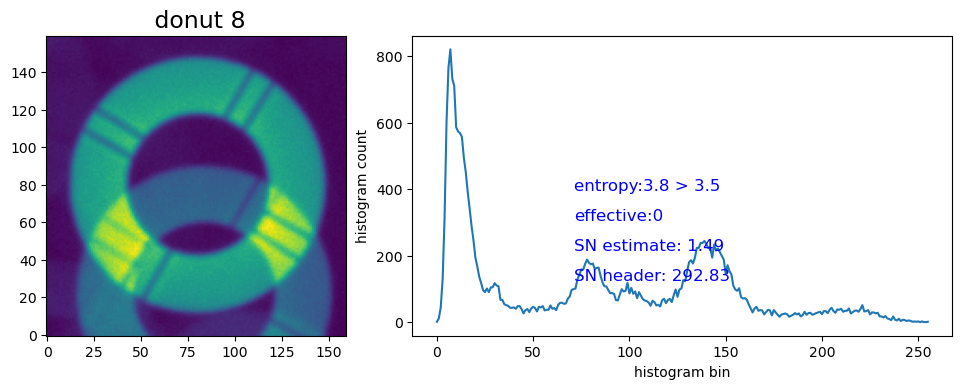

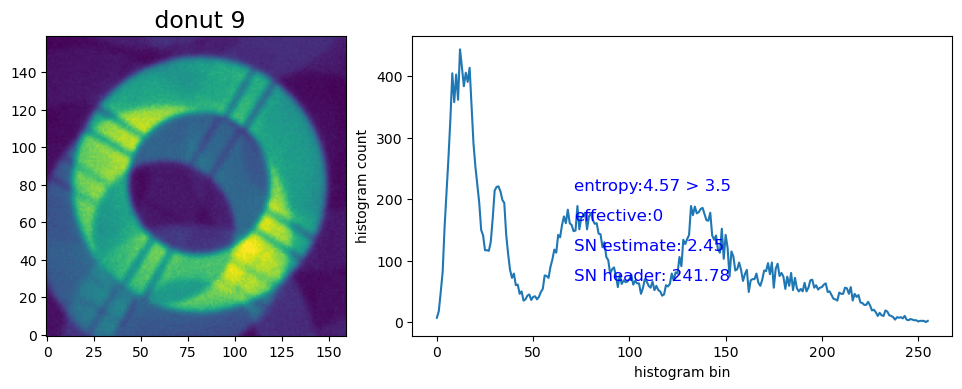

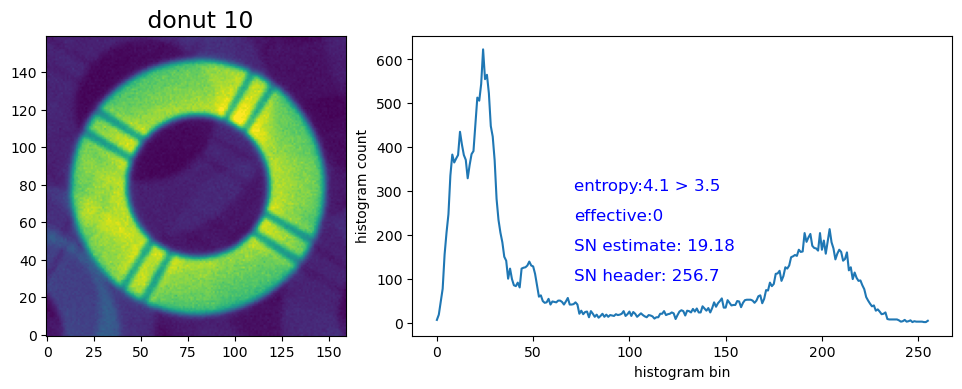

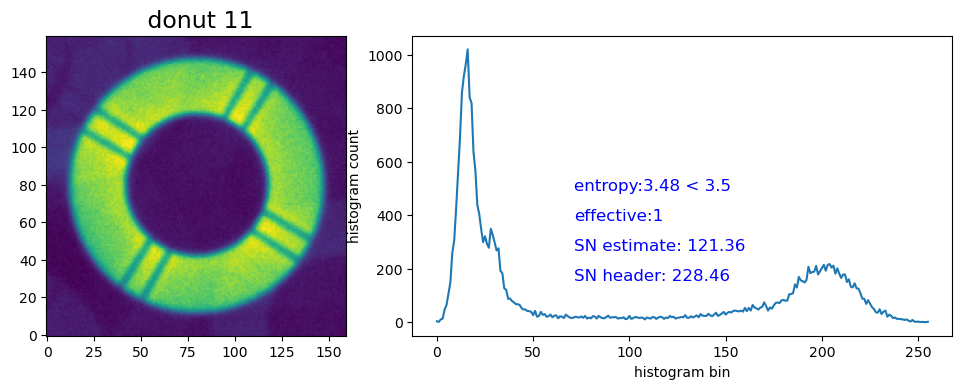

In [12]:
from astropy.visualization import ZScaleInterval
import matplotlib.lines as mlines
zscale = ZScaleInterval()

donut_stamps =   donutStampsExtra
donut_catalog = donut_catalog_direct

for i in range(len(donut_stamps)):
    plot_entropy(donut_stamps, donut_catalog, i)

So this shows that the value of entropy threshold is what we may want to set as a kwarg. Would be nice to make that plot for a lot of donuts, and thus illustrate the method what do donuts look lkike as the entropy increases. 

Collate all info from each detector:

In [13]:
entropies = []
hists = []
stamps = []
idxs = []
snratios_base = []
snratios_dilated = []
snratios_header = []
for idx in donut_info.keys():
    edic= donut_info[idx]['entropy_dic'] 
    cat = donut_info[idx]['catalog']
    for id in edic.keys():
        entropies.append(edic[id]['imgEntropy'])
        stamps.append(edic[id]['donut'])
        hists.append(edic[id]['hist'])
        idxs.append(f'{idx}{str(id).zfill(2)}')


        # donut_mean = np.mean(img * mask) 
        # background_var  : variance of image outside of model mask
        # background_dilated_var : variance of image outside of dilated model mask 
        snratios_base.append(cat['SN_RATIO_BASE'].iloc[id])#   donut_mean / background_var 
        snratios_dilated.append(cat['SN_RATIO_DILATED'].iloc[id]) # donut_mean / background_dilated_var 
        snratios_header.append(cat['SN_RATIO_HEADER'].iloc[id]) # donut_mean / bgvar 

Plot relationship between entropy estimate and the SN measure 

What is the relationship between the entropy measure and the different SN ratio estimates ? 

Text(0, 0.5, 'SN ratio header variance')

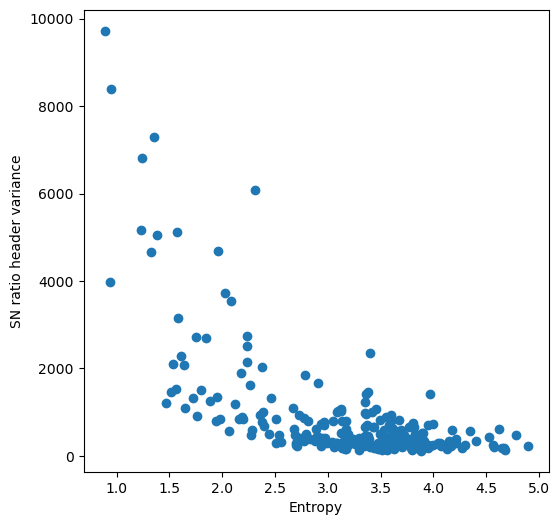

In [14]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
#ax.scatter(entropies, snratios_base, label='model mask')
#ax.scatter(entropies, snratios_dilated, label='dilated mask')
ax.scatter(entropies, snratios_header, label='header bgvar')
ax.set_xlabel('Entropy')
ax.set_ylabel('SN ratio header variance')

Plot all donut image histograms colored by the calculated Shannon entropy measure:

Text(0, 0.5, 'count')

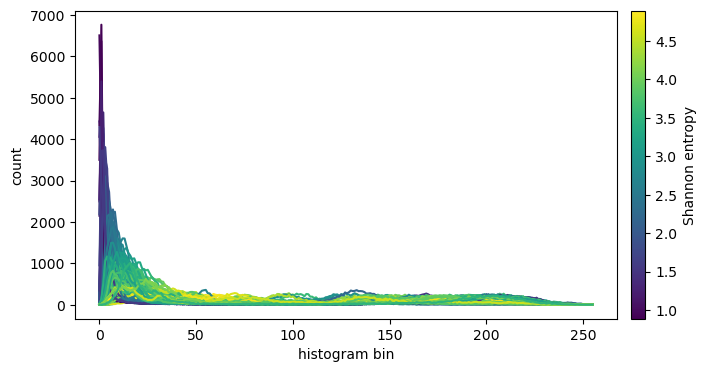

In [15]:
import matplotlib.colorbar as cbar 

nlines = len(entropies)
color_idx = np.linspace(0, 1, nlines)

z = np.array(entropies)

# Create a colormap
cmap = plt.cm.viridis

# Normalize the data
norm = plt.Normalize(vmin=z.min(), vmax=z.max())
normed_z = norm(z)

# Plot the data
fig,ax = plt.subplots(1,1,figsize=(7,4))
for i in range(len(z)):
    ax.plot(hists[i], color=cmap(normed_z[i]))

bbox = ax.get_position()
mins, maxs = bbox.get_points()
xmin,ymin = mins
xmax, ymax = maxs

cax = fig.add_axes([xmax+0.02,ymin,0.02,ymax-ymin])

cb1 = cbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Shannon entropy')
ax.set_xlabel('histogram bin')
ax.set_ylabel('count')

Illustrate donuts spanning different values of donut image stamp entropy:

In [16]:
def plot_stamp_entropy(stamp, entropy, hist, i,entroThres=3.5):
    fig = plt.figure(figsize=(9,3))#1, figsize=(3*edge, n_donuts*edge))
    ax1 = fig.add_axes([0, 0, 0.4, 1])
    ax2 = fig.add_axes([0.44, 0, 0.6, 1])
    
    vmin,vmax = zscale.get_limits(stamp)
    
    ax1.imshow(stamp, vmin=vmin, vmax=vmax, origin="lower")
    ax1.set_title(f" donut {i}", fontsize=17, c="black")

    ax2.plot(hist)

    text_dict = {'color':'b', 'fontsize':12, 'horizontalalignment':'left',
         'verticalalignment':'center'}
    sgn = '<'  if entropy<entroThres else '>'
    # position in axis2 coords 
    x1 = 0.3  ;  y1 = 0.4 ;  dy = 0.1 
    ax2.text(x1,y1+dy, f'entropy:{np.round(entropy,2)} {sgn} {entroThres}',  transform=ax2.transAxes,  **text_dict)
    #ax2.text(x1,y1,f'effective:{eff}',  transform=ax2.transAxes,**text_dict)
    #ax2.text(x1,y1-dy,f'SN estimate: {np.round(sn1,2)}',  transform=ax2.transAxes, **text_dict)
    #ax2.text(x1,y1-2*dy,f'SN header: {np.round(sn2,2)}', transform=ax2.transAxes, **text_dict)
    ax2.set_ylabel('histogram count')
    ax2.set_xlabel('histogram bin')

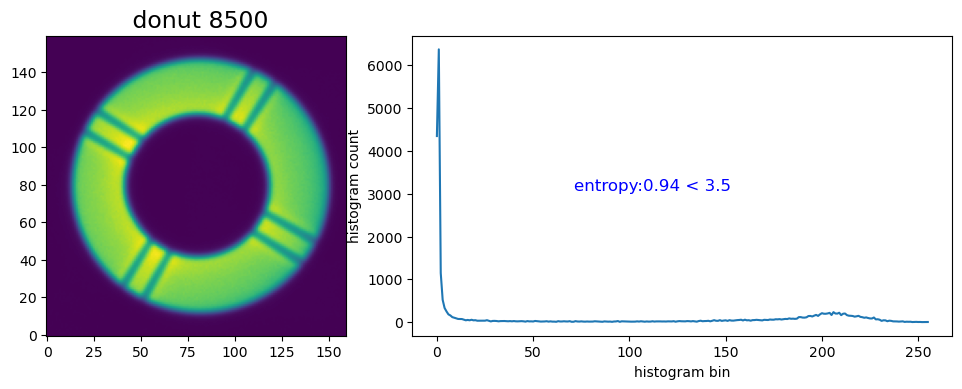

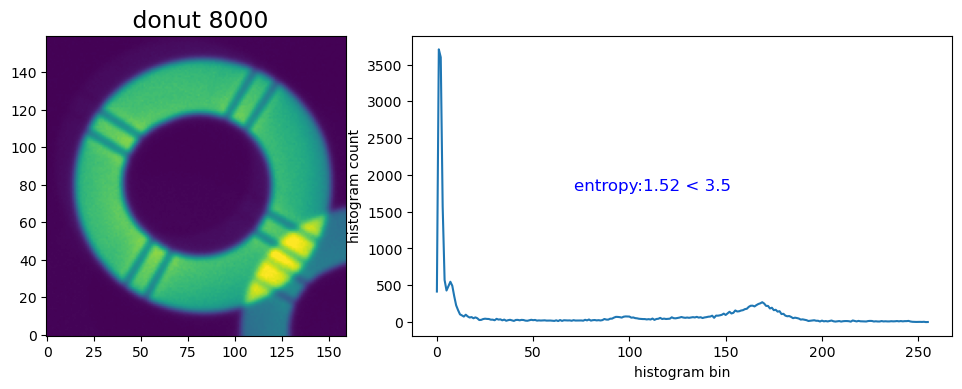

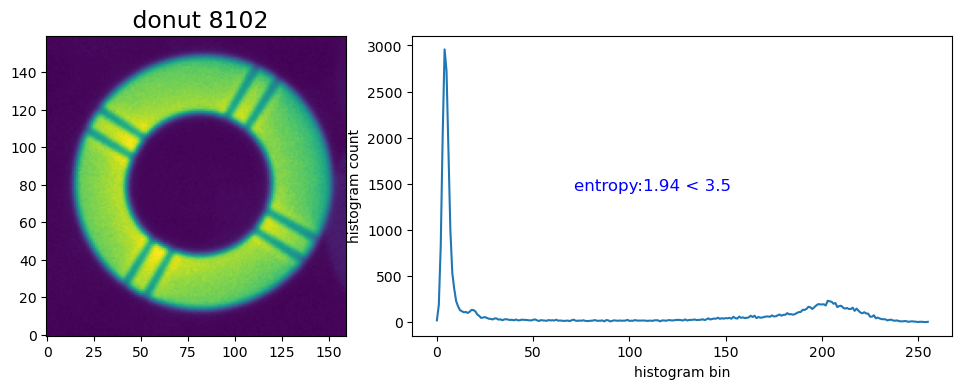

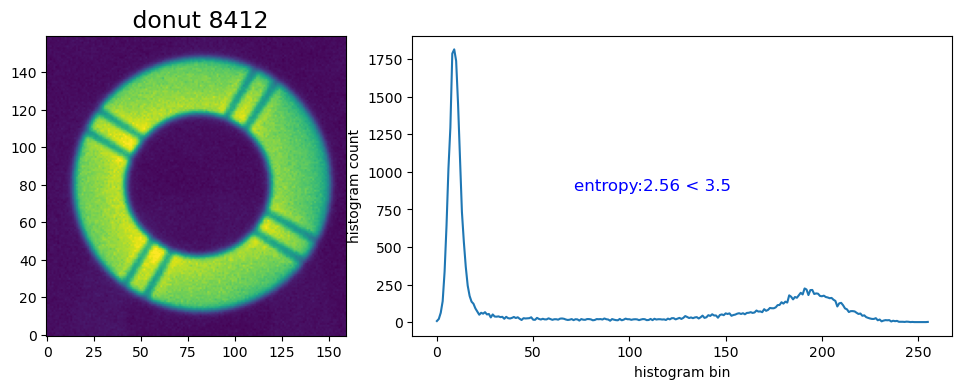

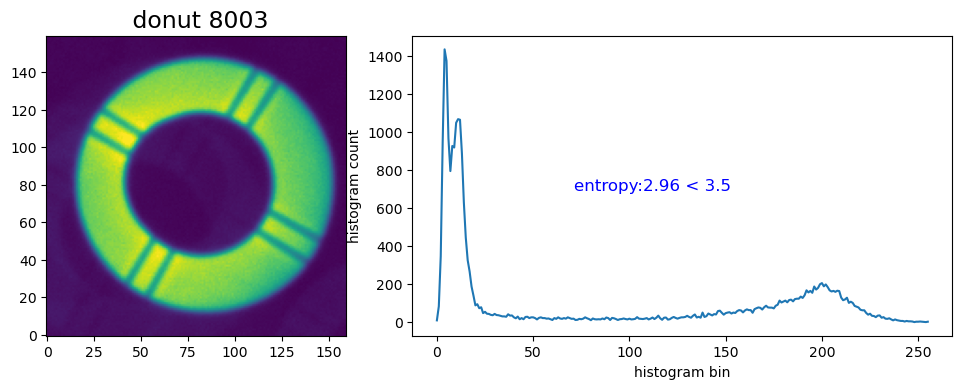

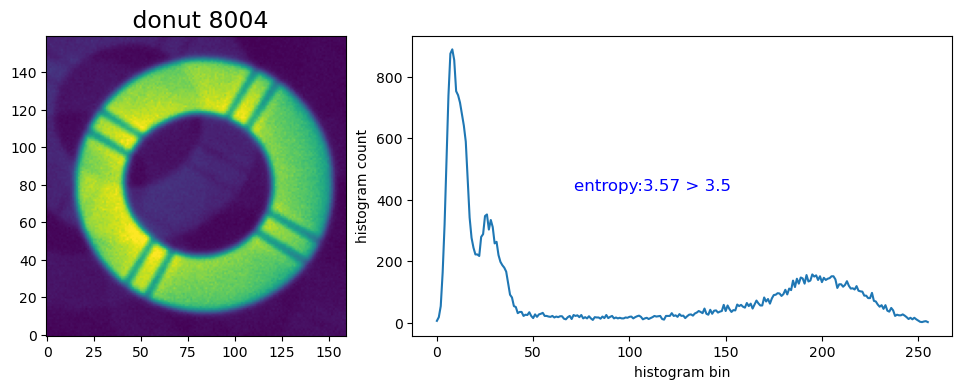

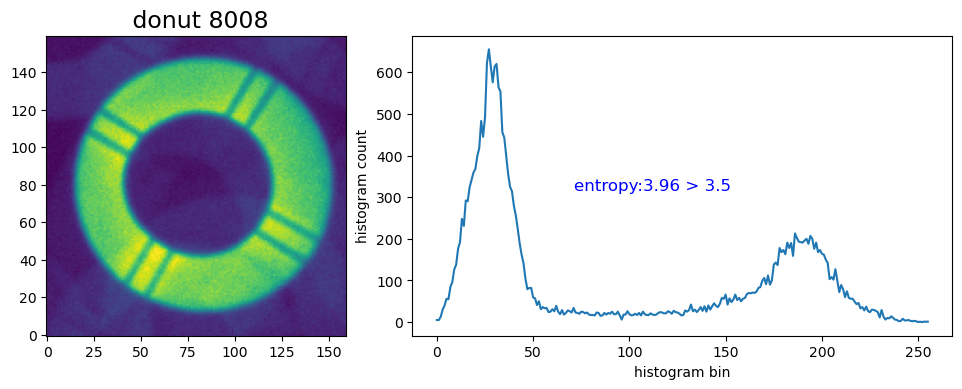

In [17]:
entropies_array = np.array(entropies)
for value in np.arange(1,4.5,0.5):

    mask = np.abs(entropies_array - value) < 0.1
    
    if np.sum(mask)>0:
        entropies_select = entropies_array[mask]
        hist_select = np.array(hists)[mask]
        stamps_select = np.array(stamps)[mask]
        idx_select = np.array(idxs)[mask]
        plot_stamp_entropy(stamps_select[0], entropies_select[0], hist_select[0], idx_select[0])
    

Also, consider cutting out random parts of a single exposure, to show that a totally bad donut would rather get rejected:

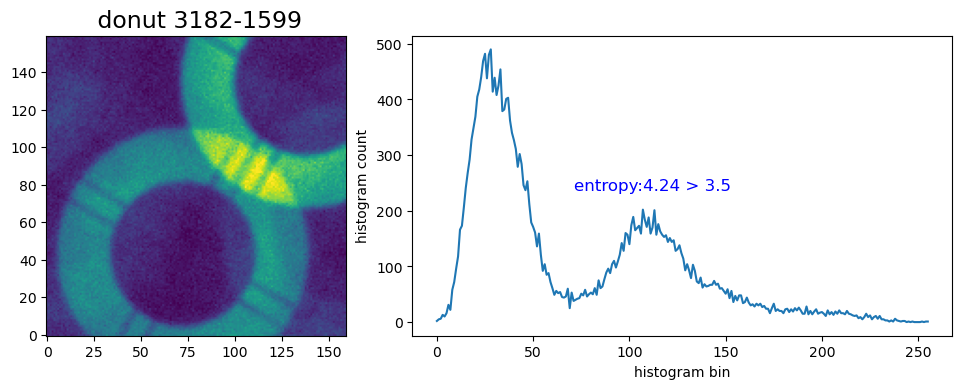

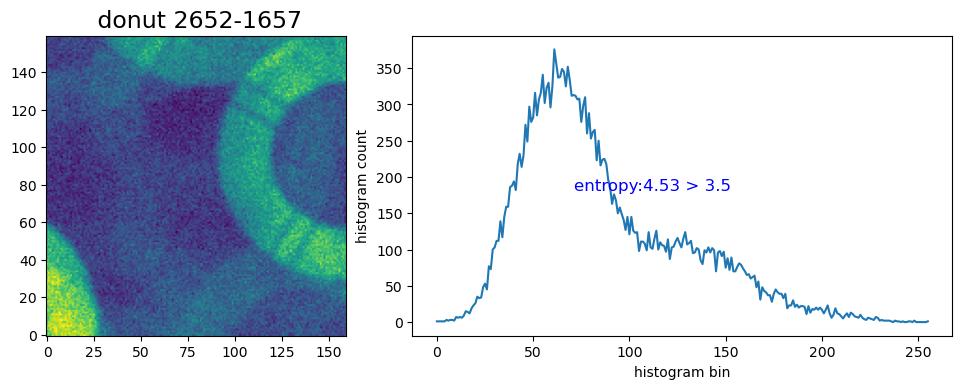

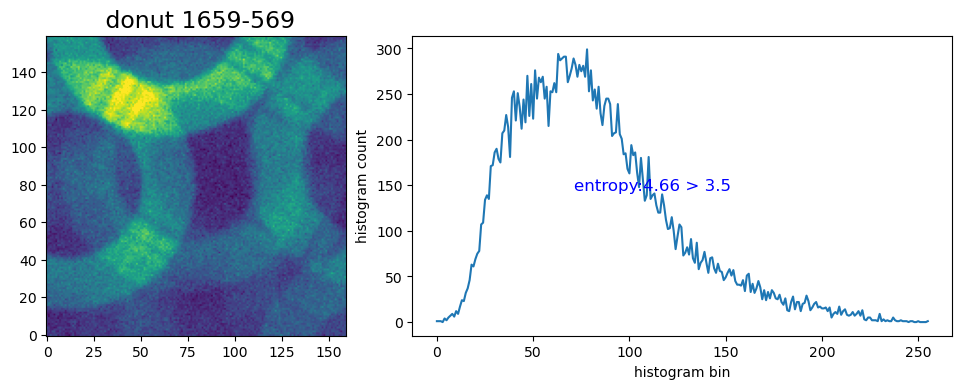

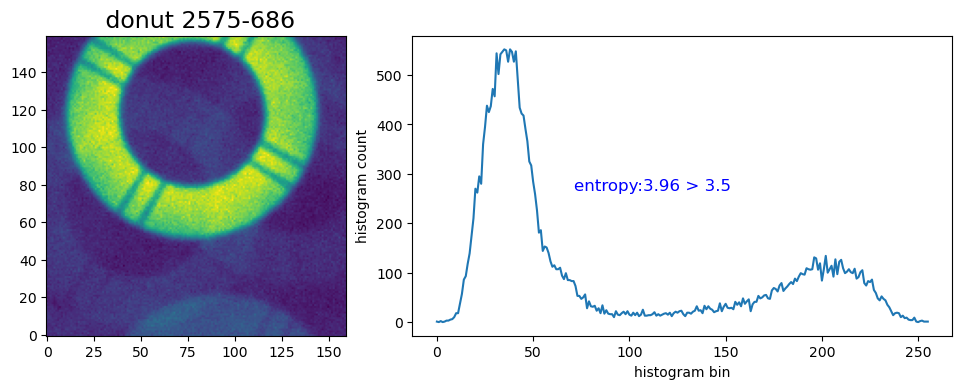

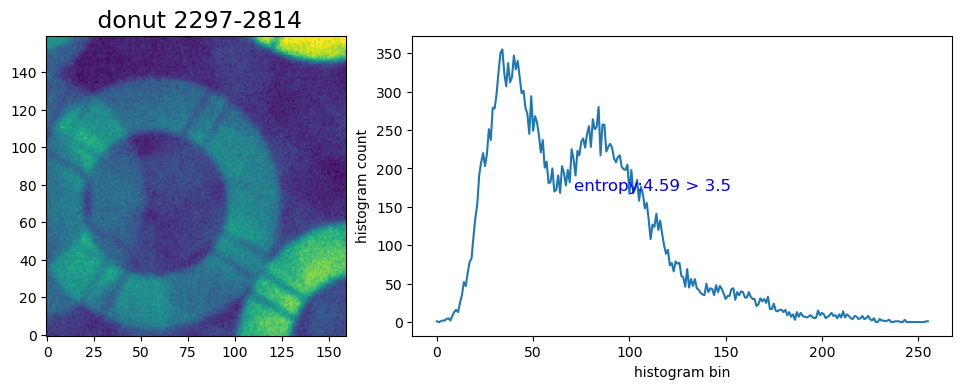

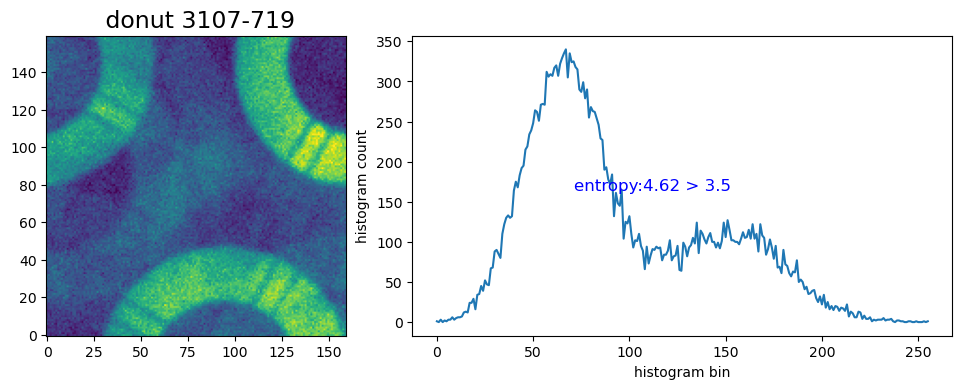

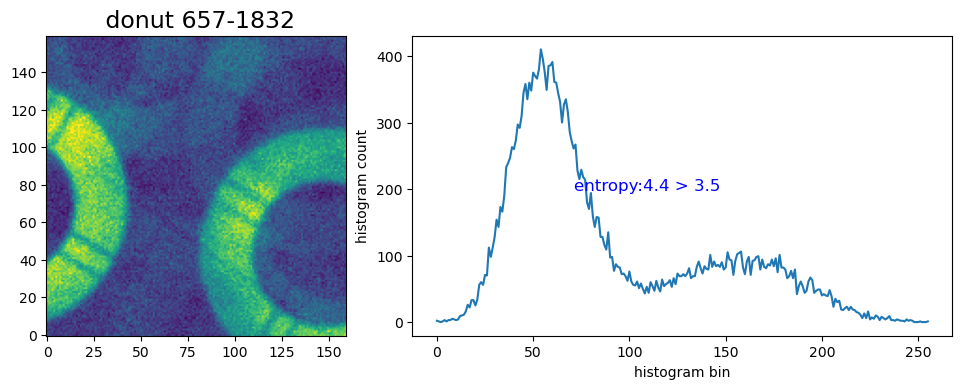

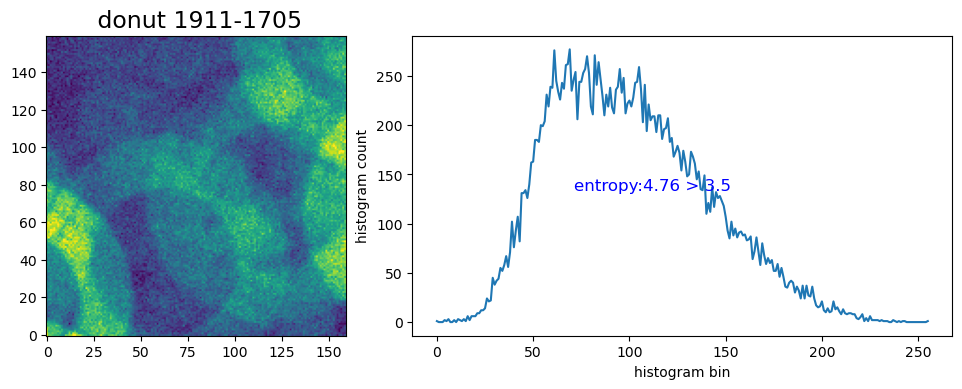

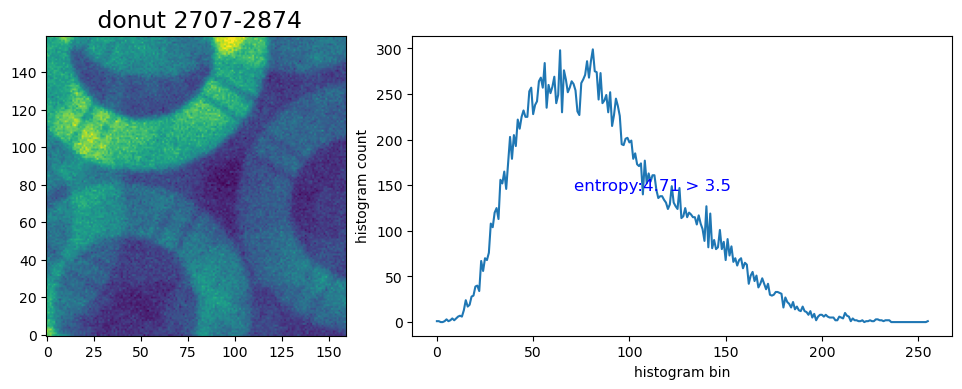

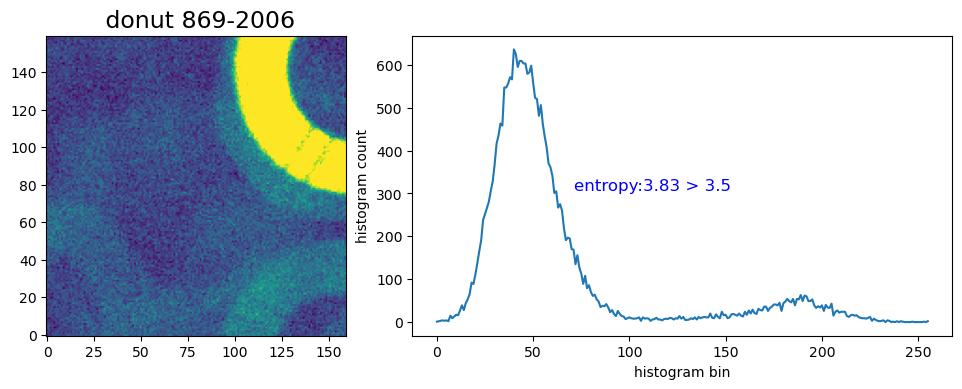

In [18]:
d = exposure_intra.image.array
vmin,vmax = zscale.get_limits(d)
for i in range(10):

    xc = np.random.randint(160,4000)
    yc = np.random.randint(160,4000)
    hw = 80
    stamp_random = d[xc-hw:xc+hw, yc-hw:yc+hw]
    ii = f'{xc}-{yc}'
    
    numOfBins = 256
    hist_stamp = np.histogram(stamp_random.flatten(), bins=numOfBins)[0]
    entropy_stamp = entropy(hist_stamp**2)
    
    plot_stamp_entropy(stamp_random, entropy_stamp, hist_stamp, ii)
        

Signature:
entropy(
    pk: 'np.typing.ArrayLike',
    qk: 'np.typing.ArrayLike | None' = None,
    base: 'float | None' = None,
    axis: 'int' = 0,
) -> 'np.number | np.ndarray'
Docstring:
Calculate the Shannon entropy/relative entropy of given distribution(s).

If only probabilities `pk` are given, the Shannon entropy is calculated as
``H = -sum(pk * log(pk))``.

If `qk` is not None, then compute the relative entropy
``D = sum(pk * log(pk / qk))``. This quantity is also known
as the Kullback-Leibler divergence.

This routine will normalize `pk` and `qk` if they don't sum to 1.

Parameters
----------
pk : array_like
    Defines the (discrete) distribution. Along each axis-slice of ``pk``,
    element ``i`` is the  (possibly unnormalized) probability of event
    ``i``.
qk : array_like, optional
    Sequence against which the relative entropy is computed. Should be in
    the same format as `pk`.
base : float, optional
    The logarithmic base to use, defaults to ``e`` (natural logari